Found 5487 rows with NaN values
Found 1874 rows with NaN values
Found 1869 rows with NaN values
                Feature       VIF
5           days_active  7.273604
3          total_clicks  6.816702
4          n_activities  3.101208
6        clicks_per_day  2.499495
2        weighted_score  2.004465
1       studied_credits  1.074742
0  num_of_prev_attempts  1.053615
7     date_registration  1.030872


C:\Users\User\anaconda3\envs\text_analytics\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:11:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Model Performance ===
Validation Accuracy: 0.7759705385913764
              precision    recall  f1-score   support

           0       0.73      0.82      0.78      3076
           1       0.82      0.73      0.78      3441

    accuracy                           0.78      6517
   macro avg       0.78      0.78      0.78      6517
weighted avg       0.78      0.78      0.78      6517

Test Accuracy: 0.7772155780435449
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      3079
           1       0.83      0.73      0.78      3443

    accuracy                           0.78      6522
   macro avg       0.78      0.78      0.78      6522
weighted avg       0.78      0.78      0.78      6522



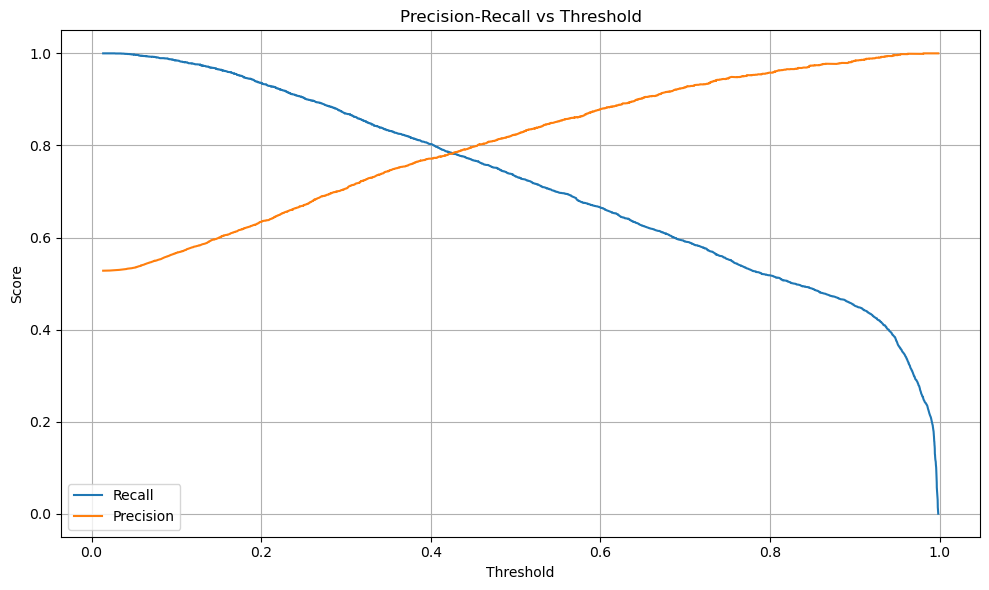

Best threshold with recall ≥ 0.90: 0.254
Recall: 0.900, Precision: 0.673

=== Evaluation at threshold 0.254 ===
Validation Accuracy: 0.7164339419978518
              precision    recall  f1-score   support

           0       0.82      0.51      0.63      3076
           1       0.67      0.90      0.77      3441

    accuracy                           0.72      6517
   macro avg       0.75      0.71      0.70      6517
weighted avg       0.74      0.72      0.70      6517

Test Accuracy: 0.7252376571603802
              precision    recall  f1-score   support

           0       0.83      0.53      0.64      3079
           1       0.68      0.90      0.78      3443

    accuracy                           0.73      6522
   macro avg       0.75      0.71      0.71      6522
weighted avg       0.75      0.73      0.71      6522

Validation ROC AUC: 0.8620
Test ROC AUC: 0.8631
Validation PR AUC: 0.8963
Test PR AUC: 0.8953

Top Important Features:
['weighted_score', 'days_active', 'studie

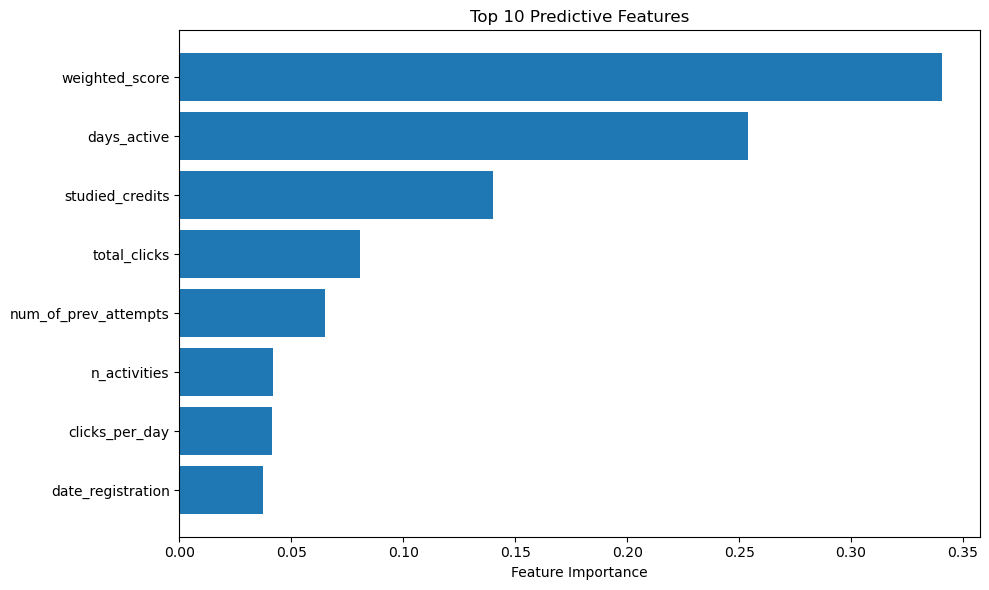

Top features by ANOVA F-test:
['weighted_score', 'days_active', 'total_clicks', 'n_activities', 'clicks_per_day', 'studied_credits', 'num_of_prev_attempts', 'date_registration']
Number of overlapping features: 8
Common features: ['date_registration', 'studied_credits', 'days_active', 'total_clicks', 'clicks_per_day', 'n_activities', 'weighted_score', 'num_of_prev_attempts']


In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

def prepare_data(set_dir, week=None):
    data_dir = Path.home() / "OneDrive" / "Desktop" / "Logistic Regression Skewness Fixed" / "constant"
    assessments = pd.read_csv(f"{data_dir}/assessments.csv")
    student_info = pd.read_csv(f"{set_dir}/student_info.csv")
    student_assessment = pd.read_csv(f"{set_dir}/student_assessment.csv")
    student_reg = pd.read_csv(f"{set_dir}/student_reg.csv")
    student_vle = pd.read_csv(f"{set_dir}/student_vle.csv")
    
    if week is not None:
        student_vle = student_vle[(student_vle['date'] // 7) <= week]
        student_assessment = student_assessment[(student_assessment['date_submitted'] // 7) <= week]

        # student_reg['week_registered'] = student_reg['date_registration'] // 7
        # student_reg['days_since_registration'] = (week * 7) - student_reg['date_registration']
        # student_reg['days_since_registration'] = student_reg['days_since_registration'].clip(lower=0) 
        
        student_assessment = pd.merge(
            student_assessment, 
            assessments[['id_assessment', 'weight', 'assessment_type']], 
            on='id_assessment', 
            how='left'
        )
    
        student_assessment = student_assessment[student_assessment['weight'] > 0] 
        student_assessment = student_assessment[student_assessment['assessment_type'] != 'Exam']
    
        # Aggregate assessments per student
        student_agg = student_assessment.groupby(
            ['code_module', 'code_presentation', 'id_student']
        ).agg(
            mean_score=('score', 'mean'),
            max_score=('score', 'max'),
            min_score=('score', 'min'),
            n_assessments=('score', 'count'),
            weighted_score=('score', lambda x: (x * student_assessment.loc[x.index, 'weight']).sum() / 100)
        ).reset_index()
    
        vle_agg = student_vle.groupby(['code_module', 'code_presentation', 'id_student']).agg(
        total_clicks=('sum_click', 'sum'),
        n_activities=('id_site', 'nunique'),
        days_active=('date', 'nunique')
        ).reset_index()

        vle_agg['clicks_per_day'] = vle_agg['total_clicks'] / vle_agg['days_active']
        
        merge_keys = ['code_module', 'code_presentation', 'id_student']
        df = student_info.merge(student_agg, on=merge_keys, how='left')
        df = df.merge(vle_agg, on=merge_keys, how='left')
        df = pd.merge(df, student_reg, on=merge_keys, how='left')
    
        nan_rows = df[df.isna().any(axis=1)]
        print(f"Found {len(nan_rows)} rows with NaN values")
        # print(nan_rows.head())
    
        assessment_cols = ['mean_score', 'max_score', 'min_score', 'weighted_score']
        df[assessment_cols] = df[assessment_cols].fillna(-1)  # -1 indicates no assessments
        df['n_assessments'] = df['n_assessments'].fillna(0)   # 0 assessments completed
        
        df['total_clicks'] = df['total_clicks'].fillna(0)
        df['n_activities'] = df['n_activities'].fillna(0)
        df['clicks_per_day'] = df['clicks_per_day'].fillna(0)
        df['days_active'] = df['days_active'].fillna(0)
    
        df = df.drop(columns=['date_unregistration', 'mean_score', 'max_score', 'min_score'], errors='ignore')
    
        df = df.drop(columns=['n_assessments']) # because of multicollinearity
        # Dropping equity related  features
        df = df.drop(columns=['disability_Y', 'age_band', 'imd_band', 'highest_education', 'gender_M'])
        # Dropping regions
        df = df.drop(columns=[reg for reg in df.columns if reg.startswith('region_')])
        
        y = df['final_result'].apply(lambda x: 1 if x in ['Fail', 'Withdrawn'] else 0)  # binary target
    
        X = df.drop(columns=['code_module', 'code_presentation', 'id_student', 'final_result'])
        
        return X, y
    else:
        pass
        

def plot_precision_recall_threshold_curve(y_true, y_probs, desired_recall=None):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

    plt.figure(figsize=(10, 6))
    # recall array has one more element than thresholds, so slice recall[:-1] 
    plt.plot(thresholds, recall[:-1], label='Recall')
    # precision array has one more element than thresholds, so slice precision[:-1] 
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if desired_recall:
        # Gets all indices where recall is at least desired_recall
        indices = np.where(recall >= desired_recall)[0]
        if len(indices) > 0:
            # Picks the one with the highest precision
            best_i = indices[np.argmax(precision[indices])]
            # Gets the threshold corresponding to that best index
            best_threshold = thresholds[best_i]
            print(f"Best threshold with recall ≥ {desired_recall:.2f}: {best_threshold:.3f}")
            print(f"Recall: {recall[best_i]:.3f}, Precision: {precision[best_i]:.3f}")
            return best_threshold
        else:
            print(f"No threshold found with recall ≥ {desired_recall}")
            return None
    return None


def evaluate_model(model, X_val, y_val, X_test, y_test):
    print("\n=== Model Performance ===")
    y_val_pred = model.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))
    
    y_test_pred = model.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    
    # Gets predicted probabilities for the positive class (1)
    y_val_probs = model.predict_proba(X_val)[:, 1]
    y_test_probs = model.predict_proba(X_test)[:, 1]
    # Getting the best threshold from our function
    threshold = plot_precision_recall_threshold_curve(y_val, y_val_probs, desired_recall=0.9)

    if threshold is not None:
       # Converting the predicted probabilities on the validation set into binary predictions using the chosen threshold.
       y_val_pred_thresh = (y_val_probs >= threshold).astype(int)
       print(f"\n=== Evaluation at threshold {threshold:.3f} ===")
       print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_thresh))
       print(classification_report(y_val, y_val_pred_thresh))
    
       y_test_pred_thresh = (y_test_probs >= threshold).astype(int)
       print("Test Accuracy:", accuracy_score(y_test, y_test_pred_thresh))
       print(classification_report(y_test, y_test_pred_thresh))
        
    # Calculates AUC
    val_pr_auc = average_precision_score(y_val, y_val_probs)
    test_pr_auc = average_precision_score(y_test, y_test_probs)
    val_roc_auc = roc_auc_score(y_val, y_val_probs)
    test_roc_auc = roc_auc_score(y_test, y_test_probs)
    
    print(f"Validation ROC AUC: {val_roc_auc:.4f}")
    print(f"Test ROC AUC: {test_roc_auc:.4f}")
    print(f"Validation PR AUC: {val_pr_auc:.4f}")
    print(f"Test PR AUC: {test_pr_auc:.4f}")

def calc_shap_values(model_name, model, X_test, feature_names):
    print(f"\nSHAP values for {model_name}:")
    X_test_for_shap = X_test.copy()
    bool_cols = X_test_for_shap.select_dtypes(include='bool').columns
    X_test_for_shap[bool_cols] = X_test_for_shap[bool_cols].astype(int)
    # Creates explainer and get Explanation object
    explainer = shap.TreeExplainer(model, X_test_for_shap)
    shap_values = explainer(X_test_for_shap)  # This returns an Explanation object
    
    # Summary plot
    shap.summary_plot(shap_values, features=X_test_for_shap, feature_names=feature_names)

def compute_vif(scaled_data, original_columns):
    # Converts scaled features into DataFrame
    X_df = pd.DataFrame(scaled_data, columns=original_columns.columns)
    
    # Computes VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    
    # Shows high-VIF features
    print(vif_data.sort_values("VIF", ascending=False))

data_dir = Path.home() / "OneDrive" / "Desktop" / "Logistic Regression Skewness Fixed" / "constant"

X_train, y_train = prepare_data(data_dir / "train", 10)
X_val, y_val = prepare_data(data_dir / "val", 10)
X_test, y_test = prepare_data(data_dir / "test", 10)

scaler = StandardScaler()

# Scaling ony for VIF; for RF it is not required
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) 
X_test_scaled = scaler.transform(X_test)

compute_vif(X_train_scaled, X_train)

# Training
model = XGBClassifier(
    n_estimators=100, # number of trees
    scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1), # Fixes class imbalance
    learning_rate=0.1, # Step size shrinkage used in update to prevent overfitting
    max_depth=6,  # default
    subsample=0.8, # Prevents overfitting by using only 80% of data per tree (row sampling)
    colsample_bytree=0.8, # Uses 80% of features per tree (column sampling) — adds regularization
    random_state=42, # For reproducability
    use_label_encoder=False, # to suppress warning
    eval_metric='logloss', # for binary classification
    n_jobs=-1 # Parallelizes training across all CPU cores
)

model.fit(X_train, y_train)

evaluate_model(model, X_val, y_val, X_test, y_test)

# Gets feature importance from logistic regression coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_ 
}).sort_values('Importance', ascending=False)

top_xgb_features = feature_importance['Feature'].tolist()
print("\nTop Important Features:")
print(top_xgb_features)
#print(feature_importance[feature_importance['Feature'].isin(top_coef_features)])

# Plots the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Predictive Features')
plt.gca().invert_yaxis()  # Show most important at top
plt.tight_layout()
plt.show()

#calc_shap_values("xgboost", model, X_test, top_xgb_features)

# ====ANOVA======
selector = SelectKBest(f_classif, k='all') # This applies the ANOVA F-test to every feature.
selector.fit(X_train_scaled, y_train)

anova_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F_score': selector.scores_
}).sort_values('F_score', ascending=False)

# Top features by ANOVA F-test
top_anova_features = anova_scores['Feature'].tolist()
print("Top features by ANOVA F-test:")
print(top_anova_features)

common_features = set(top_xgb_features) & set(top_anova_features)
print(f"Number of overlapping features: {len(common_features)}")
print("Common features:", list(common_features))

#calc_shap_values("anova (model agnostic)", model, X_test, top_anova_features)

selector = SelectFromModel(model, threshold='median', prefit=True)
# threshold='median' will keep only those features whose importance is greater than the median importance value of all features.
# prefit=True tells SelectFromModel not to re-fit the model.
X_train_reduced = selector.transform(X_train)
X_val_reduced = selector.transform(X_val)
X_test_reduced = selector.transform(X_test)

# Retraining
model_reduced = XGBClassifier(
    n_estimators=100,
    scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
model_reduced.fit(X_train_reduced, y_train)

evaluate_model(model_reduced, X_val_reduced, y_val, X_test_reduced, y_test)

selected_features = X_train.columns[selector.get_support()]
# After model training on reduced features
final_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': model_reduced.feature_importances_ 
}).sort_values('Importance', ascending=False)

print("\nFinal Importance: ")
print(final_importance)

# Plots feature importance
plt.figure(figsize=(10, 6))
plt.barh(final_importance['Feature'], final_importance['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#calc_shap_values("reduced model", model_reduced, X_test_reduced, selected_features)